In [ ]:
%pip install thundersvm

: 

In [22]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 2.7/2.7 GB 783.0 kB/s eta 0:00:00
     ---------------------------------------- 4.9/4.9 MB 24.1 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 14.1 MB/s eta 0:00:00
     ---------------------------------------- 5.7/5.7 MB 21.5 MB/s eta 0:00:00
     ------------------------------------- 536.2/536.2 kB 11.2 MB/s eta 0:00:00


In [ ]:
"""
Adopt reduced data set (2000 examples, 500 for each category),
Get features from pipeline1, 2, 3 and pass it LDA and SVN. Do the grid search.
- pipeline1 (Canny + SIFT):
	preprocess: grayscale, histogram_clipping, gaussian_blur_preprocessing, bilateral_preprocessing, sobel_preprocessing, canny_filter, center_crop
	feature extractor: sift_bag_of_visual_words (200 features)
	feature reduction: no PCA needed, normalized feature-wise by dividing maximum
	classifier LDA + linear regression: train_accuracy: 0.63 , val_accuracy: 0.45
	classifier SVM (non-linae, 'rbf'): train_accuracy: 0.71 , val_accuracy: 0.51
	arguments for grid search: number of PCA features, C of SVM, C of linear regression
- pipeline2 (HOG):
	preprocess: grayscale, histogram_clipping, gaussian_blur_preprocessing, bilateral_preprocessing, center_crop
	feature extractor: hog feature (63504 features)
	feature reduction: PCA, from 63504 down to 200 features, z score normalization needed.
	classifier LDA + linear regression: train_accuracy: 0.8 , val_accuracy: 0.65 (L1 regularization)
	classifier SVM (non-linae, 'rbf'): train_accuracy: 0.95, val_accuracy: 0.64
	arguments for grid search: number of PCA features, C of SVM, C of linear regression and L regularization
- pipeline3 (Resnet50):
	preprocess: N/A
	feature extractor: body of resnet50 (detach classifer head) (2048 features)
	feature reduction: PCA, from 2048 down to 100 features, no normalization needed.
	classifier LDA + linear regression: train_accuracy: 0.28 , val_accuracy: 0.05 (L1 regularization)
	classifier SVM (non-linae, 'rbf'): train_accuracy: 0.89 , val_accuracy: 0.41
	arguments for grid search: number of PCA features, C of SVM, C of linear regression and L1 regularization
"""

from google.colab import drive
# mount Google Drive
drive.mount("/content/drive")

In [1]:
# copy the filters from ex7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color
from scipy.cluster.vq import kmeans

np.random.seed(62)
from scipy.cluster.vq import vq

ModuleNotFoundError: No module named 'cv2'

## Data imports
If using local: use the second code block

In [ ]:
# training data
import pandas as pd

csv_file_path = "/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv"
column_names = ["path", "index", "label"]
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)
print(df_train.shape)
# val data
import pandas as pd

csv_file_path = "/content/drive/MyDrive/galaxy_zoo/val_data_reduced.csv"
column_names = ["path", "index", "label"]
df_val = pd.read_csv(csv_file_path, names=column_names)
df_val = df_val.iloc[1:]
df_val = df_val.reset_index(drop=True)
print(df_val.shape)
# test data
csv_file_path = "/content/drive/MyDrive/galaxy_zoo/test_data_reduced.csv"
column_names = ["path", "index", "label"]
df_test = pd.read_csv(csv_file_path, names=column_names)
df_test = df_test.iloc[1:]
df_test = df_test.reset_index(drop=True)
print(df_test.shape)

In [2]:
import pandas as pd


def read_data(csv_file_path):
    """
    Read data and remove file paths that are duplicates
    """
    # csv_file_path = "./"
    column_names = ["path", "index", "label"]
    df = pd.read_csv(csv_file_path, names=column_names)
    df["path"] = df["path"].map(
        lambda x: "Train_images/Train_images/" + "/".join(x.split("/")[-2:])
    )
    df = df[~df["path"].str.contains("(1)", regex=False)]
    df = df.iloc[1:]
    df = df.reset_index(drop=True)
    return df


df_train = read_data("train_data.csv")
df_test = read_data("test_data.csv")
df_val = read_data("val_data.csv")

In [3]:
df_test

,path,index,label
0,Train_images/Train_images/Cigar-shaped smooth/...,235228,Class0
1,Train_images/Train_images/Cigar-shaped smooth/...,624444,Class0
2,Train_images/Train_images/Cigar-shaped smooth/...,601143,Class0
3,Train_images/Train_images/Cigar-shaped smooth/...,101135,Class0
4,Train_images/Train_images/Cigar-shaped smooth/...,347906,Class0
...,...,...,...
2874,Train_images/Train_images/spiral/346113.jpg,346113,Class4
2875,Train_images/Train_images/spiral/332813.jpg,332813,Class4
2876,Train_images/Train_images/spiral/149207.jpg,149207,Class4
2877,Train_images/Train_images/spiral/364853.jpg,364853,Class4


## Data logging and input

In [47]:
import json
from uuid import uuid4


def create_vector_metadata_dict():
    if not os.path.exists("pipelines"):
        os.makedirs("pipelines")
    # create a dictionary to store the metadata of the vectors
    if not os.path.exists("pipelines/metadata.json"):
        vector_metadata = dict()
        with open("pipelines/metadata.json", "w") as file:
            file.write(json.dumps(vector_metadata))


def read_vector_metadata_dict(vector_attributes: dict) -> pd.DataFrame | None:
    """
    Vector metadata dict should be a dictionary with keys as names of the uuid vector csv files,
    and values as dictionaries with keys as the metadata of the vector csv.
    """
    if not os.path.exists("pipelines/metadata.json"):
        create_vector_metadata_dict()
    with open("pipelines/metadata.json", "r") as file:
        vector_metadata = json.load(file)
    # if there is a match, return the csv
    for key, value in vector_metadata.items():
        if value == vector_attributes:
            if os.path.exists(f"pipelines/{key}"):
                return pd.read_csv(f"pipelines/{key}")
            # if file doesn't exist, remove the key from the metadata
            else:
                del vector_metadata[key]
                with open("pipelines/metadata.json", "w") as file:
                    file.write(json.dumps(vector_metadata))
                return None
    return None


def write_vector_metadata_dict(data, vector_attributes: dict) -> None:
    """
    After processing a dataset with a pipeline, take the vector attributes, and save with a unique uuid.
    Also save a into the metadata dictionary, with the {uuid}.csv as the key and the vector attributes as the value.
    """
    if not os.path.exists("pipelines/metadata.json"):
        create_vector_metadata_dict()
    with open("pipelines/metadata.json", "r") as file:
        vector_metadata = json.load(file)
    # check if there is already a match.  If so, raise an error.
    for key, value in vector_metadata.items():
        if value == vector_attributes:
            raise ValueError("Vector metadata already exists")
    # create a unique identifier
    uuid = str(uuid4())
    # write the data
    data.to_csv(f"pipelines/{uuid}.csv", index=False)
    # write the metadata
    vector_metadata[f"{uuid}.csv"] = vector_attributes
    with open("pipelines/metadata.json", "w") as file:
        file.write(json.dumps(vector_metadata))

## Preprocessing modules

In [48]:
# preprocess and pipeline
from tqdm import tqdm


def grayscale_preprocessing(img):
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0
    im_gray = np.mean(img, axis=2)
    return im_gray


def bilateral_preprocessing(img, ksize, sigmX, sigmY):
    bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
    return bilateral_filtered_image


def high_pass_preprocessing(img, ksize, sig):
    low_pass = cv2.GaussianBlur(img, ksize, 0)
    high_pass = img - low_pass
    return high_pass


def build_codebook(
    preprocessed_features,
    sample_size=1050,
    k=200,
    iters=1,
    save_location="codebook.npy",
):
    """
    Use k-means clustering to build a codebook of visual words, given a set of SIFT descriptors.
    Args:
            sample_size: number of SIFT descriptors to sample from the training set
    """
    descriptors_sample = list()
    descriptor_sample = list()
    sample_idx = np.random.randint(0, len(df_train) + 1, sample_size).tolist()
    for i in sample_idx:
        if (
            preprocessed_features[i] is not None
            and len(preprocessed_features[i].shape) == 2
        ):
            descriptors_sample.append(preprocessed_features[i])
    descriptor_sample = np.vstack(descriptors_sample)
    codebook, variance = kmeans(descriptor_sample, k, iters)
    np.save(save_location, codebook)
    return codebook


def quantize_and_create_sparse_representation(preprocessed_features, codebook):
    visual_words = []
    frequency_vectors = []
    # for each image descriptor, take every idx and
    for img_descriptors in preprocessed_features:
        if img_descriptors is None:
            visual_words.append(np.zeros(200))
            continue
        img_visual_words, distance = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)
    for img_visual_words in visual_words:
        # create a frequency vector for each image
        img_frequency_vector = np.zeros(200)
        for word in img_visual_words:
            img_frequency_vector[int(word)] += 1
        frequency_vectors.append(img_frequency_vector)
    frequency_vectors = np.stack(frequency_vectors)
    return frequency_vectors


def sift_bag_of_visual_words(img):
    sift = cv2.SIFT_create()
    image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
    keypoints, descriptors = sift.detectAndCompute(image8bit, None)
    return descriptors


def sobel_preprocessing(img, ksize):
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)  # Find x and y gradients
    sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
    magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
    if np.max(magnitude) == 0:
        return magnitude
    magnitude = magnitude / np.max(magnitude)  # normalize
    return magnitude


def gaussian_blur_preprocessing(img, ksize, sigma):
    blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
    return blurred_im


def canny_filter(img, high_threshold, low_threshold):
    # ensure the image is normalized to the range [0, 1]
    if np.max(img) != 0:
        img = img / np.max(img)
    # scale the image to the range [0, 255] and convert to 8-bit
    img_8u = np.uint8(img * 255)
    # threshold the image and get the interesting points
    # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
    # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
    # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

    im_threshold = cv2.Canny(
        image=img_8u, threshold1=low_threshold, threshold2=high_threshold
    )  # Canny Edge
    if np.max(im_threshold) == 0:
        return im_threshold
    im_threshold = im_threshold / np.max(im_threshold)  # normalize
    return im_threshold


def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty : starty + cropy, startx : startx + cropx]


def histogram_clipping(img, threshold_value):
    clipped_image = img.copy()
    # before
    # draw_histogram_gray(clipped_image)
    clipped_image[img < threshold_value / 255.0] = 0
    # Normalize the clipped_image to 0-255 for proper histogram visualization
    normalized_clipped_image = cv2.normalize(
        clipped_image,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_8UC1,
    )
    # draw_histogram_gray(clipped_image)
    return normalized_clipped_image


def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
    block_norm = "L1"  # Block normalization method
    # orientations = 9   # Number of orientation bins
    # pixels_per_cell = (8, 8)  # Size of the cell
    # cells_per_block = (3, 3)  # Size of the block

    # Compute the HOG features
    hog_features, hog_image = feature.hog(
        img_gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm=block_norm,
        visualize=True,
    )
    return hog_features, hog_image

## Data pipelines

In [49]:
def preprocess_1(df, codebook_size=200, codebook=None):
    image_dir = df["path"]  # ignore index
    preprocessed_list = []
    for i, image_path in enumerate(tqdm(image_dir)):
        im = np.array(Image.open(image_path))
        im = grayscale_preprocessing(im)
        im = histogram_clipping(im, 30)
        im = gaussian_blur_preprocessing(im, (9, 9), (10, 10))
        im = bilateral_preprocessing(im, 5, 30, 30)
        im = sobel_preprocessing(im, 31)
        # im = canny_filter(im, 70, 0)
        im = crop_center(im, 252, 252)
        sift = sift_bag_of_visual_words(im)
        preprocessed_list.append(sift)
    if codebook is None or (
        codebook is not None and codebook_size != codebook.shape[0]
    ):
        codebook = build_codebook(preprocessed_list)
    frequency_vectors = quantize_and_create_sparse_representation(
        preprocessed_list, codebook
    )
    max = np.max(frequency_vectors, axis=1)
    vector_representations_normalized = frequency_vectors / max[:, np.newaxis]
    return vector_representations_normalized


def preprocess_2(df):
    image_dir = df["path"]
    preprocessed_list = []
    for i, image_path in enumerate(tqdm(image_dir)):
        im = np.array(Image.open(image_path))
        im_gray = grayscale_preprocessing(im)
        img_histogram_clipping = histogram_clipping(im_gray, 30)
        im_blurred = gaussian_blur_preprocessing(
            img_histogram_clipping, (9, 9), (10, 10)
        )
        im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
        im_cropped = crop_center(im_bilateral, 240, 240)
        hog_feature, hog_image = hog(im_cropped)  # (63504,)
        preprocessed_list.append(hog_feature)
    # im_flattened = hog_feature.flatten()
    return np.array(preprocessed_list)


def preprocess_resnet_nopreprocess(df):
    image_dir = df["path"]
    preprocessed_list = []
    for i, image_path in enumerate(image_dir):
        im = np.array(Image.open(image_path))
        preprocessed_list.append(im)
    return preprocessed_list

In [50]:
from sklearn.decomposition import PCA


def pick_top_feature_pca(feature_matrix, top_components, n_components):
    # pick up top 100 features by PCA
    pca = PCA(n_components=n_components)
    pca.fit(feature_matrix)
    principal_components = pca.transform(feature_matrix)
    top_components_matrix = principal_components[:, :top_components]

    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Number of PCA components")
    plt.ylabel("Cumulative explained variance")
    plt.title("Explained Variance vs Number of PCA Components")
    plt.grid(True)
    plt.show()
    # Extract the top n components
    return top_components_matrix, pca


# use the pca embedding from train and process the val and test
def pick_top_feature_pca_val_test(pca_train, feature_matrix, top_components: int):
    principal_components = pca_train.transform(feature_matrix)
    top_components_matrix = principal_components[:, :top_components]
    return top_components_matrix

Resnet50

In [ ]:
images_list_nopreprocess = preprocess_resnet_nopreprocess(df_train)
print(len(images_list_nopreprocess))

In [ ]:
images_list_nopreprocess_val = preprocess_resnet_nopreprocess(df_val)
print(len(images_list_nopreprocess_val))

2881


In [8]:
images_list_no_preprocess_test = preprocess_resnet_nopreprocess(df_test)
print(len(images_list_no_preprocess_test))

2879


In [9]:
import torch
import torchvision.models as models

# load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# remove the classifier on top of resnet
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
# freeze the parameters of the feature extractor
for param in resnet.parameters():
    param.requires_grad = False
# Print the modified ResNet architecture

print(resnet)

# move the model to GPU
device = torch.device("cuda")
resnet.to(device)

c:\Users\ImmanuelDesktop\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ImmanuelDesktop\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [44]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader


# data loader
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img


# transformations to be applied to the images
transform = transforms.Compose(
    [
        # crop the image to shape of 224,224 in preprocess stage
        transforms.Resize(256),  # Step 1: Resize to 256x256
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]
)


# function to preprocess an image
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = Image.fromarray(img)
        processed_image = transform(img).unsqueeze(0)  # Add batch dimension
        processed_images.append(processed_image)
    return processed_images


custom_dataset = CustomDataset(images_list_nopreprocess, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features = resnet(batch.to(device))
        features_list.append(features)

# Concatenate features from all batches
features = torch.cat(features_list, dim=0)

print(features.shape)

NameError: name 'images_list_nopreprocess' is not defined

In [29]:
# val
custom_dataset_val = CustomDataset(images_list_nopreprocess_val, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features_val = resnet(batch.to(device))
        features_list.append(features_val)

# Concatenate features from all batches
features_val = torch.cat(features_list, dim=0)

print(features_val.shape)

torch.Size([2881, 2048, 1, 1])


In [11]:
# test
custom_dataset_test = CustomDataset(images_list_no_preprocess_test,  transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset_test, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features_test = resnet(batch.to(device))
        features_list.append(features_test)

# Concatenate features from all batches
features_test = torch.cat(features_list, dim=0)

print(features_test.shape)

torch.Size([2879, 2048, 1, 1])


In [30]:
import pandas as pd

features = features.cpu()
# reshape it to 2000,2048
reshaped_features = features.squeeze().numpy()
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], -1)
# Convert to DataFrame
df_features = pd.DataFrame(reshaped_features)
# Display the DataFrame
print(df_features.shape)
df_features.head(3)

(23032, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.323866,0.810107,0.173423,0.095104,1.097468,0.656244,0.926285,0.419996,0.242248,0.075973,...,0.286544,0.144746,0.071651,0.085822,0.249744,0.175224,0.194063,0.149440,0.253527,0.287767
1,0.281115,0.264574,0.213297,0.429184,0.467649,0.344130,0.255342,0.472110,0.422953,0.362707,...,0.377906,0.482257,0.453984,0.150207,0.247594,0.071317,0.809006,0.277254,0.585173,0.039033
2,0.301838,0.308071,0.448213,0.638293,0.682398,0.428404,0.524108,0.165699,0.141113,0.928782,...,0.590672,1.031486,0.836792,0.453696,0.654381,0.252695,0.359767,0.298241,0.734670,0.226921


In [31]:
features_val = features_val.cpu()
reshaped_features_val = features_val.squeeze().numpy()
reshaped_features_val = reshaped_features_val.reshape(
    reshaped_features_val.shape[0], -1
)
df_features_val = pd.DataFrame(reshaped_features_val)
print(df_features_val.shape)
df_features_val.head(3)

# resnet train: df_features / resnet val: df_features_val

(2881, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.510134,0.531732,0.564358,0.283559,0.808487,0.199183,0.466298,0.638799,0.302476,0.215067,...,0.101773,0.165949,0.674558,0.093893,0.491420,0.060113,0.184774,0.093184,0.187553,0.588974
1,0.218773,0.837910,0.309665,0.228205,0.433090,0.120860,0.068646,0.301544,0.360871,0.045463,...,0.265798,0.207874,0.562695,0.231727,0.499461,0.155617,0.662672,0.616920,0.091594,0.181815
2,0.144012,0.165640,0.820923,0.391705,0.238297,0.463936,0.222407,0.588128,0.252694,0.512174,...,0.247687,0.360356,0.327505,0.480008,0.321182,0.245446,0.272346,0.515320,0.403950,0.288500


In [12]:
features_test = features_test.cpu()
reshaped_features_test = features_test.squeeze().numpy()
reshaped_features_test = reshaped_features_test.reshape(
    reshaped_features_test.shape[0], -1
)
df_features_test = pd.DataFrame(reshaped_features_test)
print(df_features_test.shape)
df_features_test.head(3)

(2879, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.071336,0.218844,0.303433,0.448429,1.085989,0.746727,0.511905,0.739389,0.439367,0.238507,...,0.116314,0.395819,0.132275,0.043789,0.358311,0.134943,0.397711,0.186322,0.060069,0.265349
1,0.626142,0.251020,0.864124,0.237185,0.124343,0.903479,0.092782,0.108641,0.576048,0.750469,...,0.071972,0.531990,0.553137,0.576850,0.316697,0.302557,0.296011,0.242232,0.763575,0.747678
2,0.193286,0.750038,0.073023,0.165334,0.748972,0.655146,0.389483,0.693393,0.954382,0.188428,...,0.748377,0.414582,0.113435,0.304529,0.601162,0.199630,0.198217,0.120655,0.307602,0.531466


In [34]:
Y_train_resnet = df_train["label"]
X_train_resnet = df_features
print(X_train_resnet.shape)
Y_val_resnet = df_val["label"]
X_val_resnet = df_features_val
print(X_val_resnet.shape)
Y_test_resnet = df_test["label"]
X_test_resnet = df_features_test

(23032, 2048)


In [37]:
# save the features
np.save("pipeline3_train.npy", X_train_resnet)
np.save("pipeline3_val.npy", X_val_resnet)
np.save("pipeline3_test.npy", X_test_resnet)

Pipeline1

In [29]:
preprocessed_features = preprocess_1(df_train)
preprocessed_features.shape

100%|██████████| 23032/23032 [05:21<00:00, 71.66it/s]


(23032, 200)

In [19]:
with open("codebook.npy", "rb") as f:
    codebook = np.load(f)
preprocessed_features_val = preprocess_1(df_val, codebook=codebook)
preprocessed_features_val.shape

# pipeline1 train: preprocessed_features / pipeline1 val: preprocessed_features_val

In [31]:
Y_train_pipeline1 = df_train["label"]
# max = np.max(preprocessed_features, axis=1)
# vector_representations_normalized = preprocessed_features / max[:, np.newaxis]
X_train_pipeline1 = preprocessed_features

In [32]:
Y_val_pipeline1 = df_val["label"]
# max_val = np.max(preprocessed_features_val, axis=1)
# vector_representations_normalized_val = preprocessed_features_val / max_val[:, np.newaxis]
x_val_pipeline1 = preprocessed_features_val

In [ ]:
Y_test_pipeline1 = df_test["label"]
preprocessed_features_test = preprocess_1(df_test, codebook=codebook)
x_test_pipeline1 = preprocessed_features_test

In [43]:
# export the pipeline1 features
np.save("pipeline1_train.npy", X_train_pipeline1)
np.save("pipeline1_val.npy", x_val_pipeline1)
np.save("pipeline1_test.npy", preprocessed_features_test)

pipeline 2

In [24]:
import numpy as np

In [8]:
df_preprocessed_2_train = preprocess_2(df_train)
# df_preprocessed_2_train.columns = [
#     f"feature_{i}" for i in range(len(df_preprocessed_2_train.columns))
# ]
# print(df_preprocessed_2_train.shape)

100%|██████████| 23032/23032 [1:09:29<00:00,  5.52it/s]


In [9]:
df_preprocessed_2_val = preprocess_2(df_val)
# df_preprocessed_2_val.columns = [
#    f"feature_{i}" for i in range(len(df_preprocessed_2_val.columns))
# ]
print(df_preprocessed_2_val.shape)

100%|██████████| 2881/2881 [08:13<00:00,  5.84it/s]


(2881, 63504)


In [26]:
df_preprocessed_3_test = preprocess_2(df_test)

100%|██████████| 2879/2879 [09:31<00:00,  5.04it/s]


In [10]:
np.save("pipeline2_train_before_pca_and_normalization.npy", df_preprocessed_2_train)
np.save("pipeline2_val_before_pca_and_normalization.npy", df_preprocessed_2_val)

In [25]:
df_preprocessed_2_train = np.load("pipeline2_train_before_pca_and_normalization.npy")

In [34]:
# feature normarlization since we only pick up top 200. z score normalization
from sklearn.preprocessing import StandardScaler


def feature_normalization(df_feature, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(df_feature)
    normalized_features = scaler.transform(df_feature)
    return normalized_features, scaler

In [27]:
# save pre_pca_vectors
# df_preprocessed_2_train_normalized, scaler = feature_normalization(df_preprocessed_2_train)
# df_preprocessed_2_val_normalized, scaler = feature_normalization(df_preprocessed_2_val, scaler)
# np.save("pipeline2_pre_normalize_train.npy", df_preprocessed_2_train)
# np.save("pipeline2_pre_normalize_val.npy", df_preprocessed_2_val)

In [27]:
#df_preprocessed_2_train = np.load("pipeline2_train_before_pca_and_normalization.npy")
df_preprocessed_2_val = np.load("pipeline2_val_before_pca_and_normalization.npy")

In [28]:
del df_preprocessed_2_val

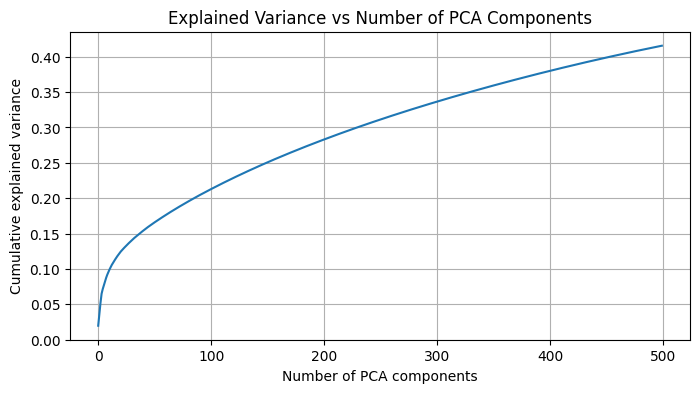

array([[-1.51278373, -1.36087422, -1.70210564, ...,  0.19310535,
         0.12897223, -0.03862977],
       [-1.68295798, -1.71877398,  0.95844495, ..., -0.04026734,
        -0.03568577,  0.0368037 ],
       [-1.10722821, -2.1972178 , -0.8681767 , ..., -0.16624584,
        -0.13546704,  0.0233147 ]])

In [30]:
train_features = df_preprocessed_2_train
val_features = df_preprocessed_2_val
test_features = df_preprocessed_3_test
top_components = 500
hog_train_pca_feature, pca_train_hog = pick_top_feature_pca(
    train_features, top_components, 500
)
# Convert PCA transformed features to DataFrame
df_top_100_feature_pca_hog_train = hog_train_pca_feature
df_top_100_feature_pca_hog_train[:3, :]

In [13]:
hog_val_pca_feature = pick_top_feature_pca_val_test(
    pca_train_hog, val_features, top_components
)
df_top_100_feature_pca_hog_val = hog_val_pca_feature
df_top_100_feature_pca_hog_val[:3, :]

array([[ 0.32370818,  0.2830298 , -1.91650369, ..., -0.05033526,
        -0.08172554, -0.12044734],
       [-1.84057534, -0.47753398,  1.79033502, ...,  0.04206816,
        -0.05891348, -0.03827909],
       [-1.58385394, -1.77813178,  0.77185801, ..., -0.15716013,
        -0.067156  , -0.0365625 ]])

In [32]:
hog_test_pca_feature = pick_top_feature_pca_val_test(
    pca_train_hog, test_features, top_components
)
df_top_100_feature_pca_hog_test = hog_test_pca_feature
df_top_100_feature_pca_hog_test[:3, :]

array([[-1.50212802,  1.70991845, -0.24471797, ...,  0.03503824,
        -0.01750141, -0.16257448],
       [-1.58840103, -2.05178394, -0.89973221, ..., -0.11669538,
         0.15000381,  0.29031861],
       [-1.96634228,  1.3043201 , -0.2638881 , ..., -0.08904858,
        -0.04828058, -0.0659168 ]])

In [36]:
df_top_100_feature_pca_hog_train_normalized, scaler = feature_normalization(
    df_top_100_feature_pca_hog_train
)
df_top_100_feature_pca_hog_val_normalized, scaler = feature_normalization(
    df_top_100_feature_pca_hog_val, scaler=scaler
)

In [37]:
df_top_100_feature_pca_hog_test_normalized, scaler = feature_normalization(
	df_top_100_feature_pca_hog_test, scaler=scaler
)

In [15]:
# save the pipeline2 features
np.save("pipeline2_train.npy", df_top_100_feature_pca_hog_train_normalized)
np.save("pipeline2_val.npy", df_top_100_feature_pca_hog_val_normalized)

In [38]:
np.save("pipeline2_test.npy", df_top_100_feature_pca_hog_test_normalized)

### Loading from previously created models

In [31]:
df_top_100_feature_pca_hog_train_normalized = np.load("pipeline2_train.npy")
df_top_100_feature_pca_hog_val_normalized = np.load("pipeline2_val.npy")
df_top_100_feature_pca_hog_test_normalized = np.load("pipeline2_test.npy")
X_train_pipeline1 = np.load("pipeline1_train.npy")
x_val_pipeline1 = np.load("pipeline1_val.npy")
X_test_pipeline1 = np.load("pipeline1_test.npy")
X_train_resnet = np.load("pipeline3_train.npy")
X_val_resnet = np.load("pipeline3_val.npy")
X_test_resnet = np.load("pipeline3_test.npy")

In [32]:
Y_train_hog = df_train["label"]
X_train_hog = df_top_100_feature_pca_hog_train_normalized
Y_val_hog = df_val["label"]
X_val_hog = df_top_100_feature_pca_hog_val_normalized
Y_test_hog = df_test["label"]
X_test_hog = df_top_100_feature_pca_hog_test_normalized

In [33]:
print(X_train_pipeline1.shape, X_train_hog.shape, X_train_resnet.shape)
print(x_val_pipeline1.shape, X_val_hog.shape, X_val_resnet.shape)
print(X_test_pipeline1.shape, X_test_hog.shape, X_test_resnet.shape)

(23032, 200) (23032, 500) (23032, 2048)
(2881, 200) (2881, 500) (2881, 2048)
(2879, 200) (2879, 500) (2879, 2048)


Combine all three sets of features

In [34]:
Y_train = df_train["label"]
Y_val = df_val["label"]
Y_test = df_test["label"]

X_train = np.hstack([X_train_pipeline1, X_train_hog, X_train_resnet])
X_val = np.hstack([x_val_pipeline1, X_val_hog, X_val_resnet])
X_test = np.hstack([X_test_pipeline1, X_test_hog, X_test_resnet])
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(23032, 2748) (2881, 2748) (2879, 2748) (23032,) (2881,) (2879,)


Post PCA (just wanna see the variance)

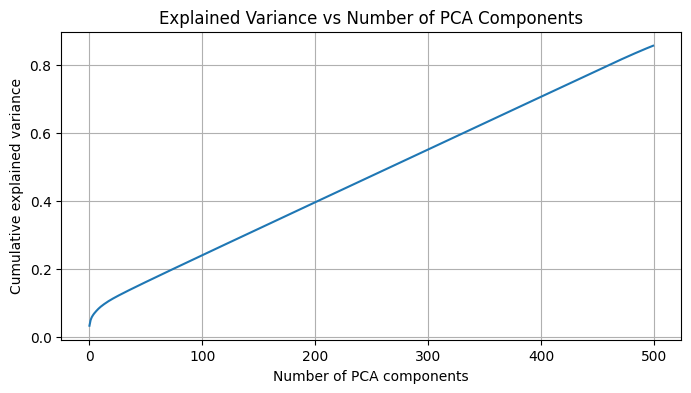

In [13]:
top_components = 200
allpipeline_feature_train_pca, pca_all = pick_top_feature_pca(
    X_train, top_components, 500
)
allpipeline_feature_val_pca = pick_top_feature_pca_val_test(
    pca_all, X_val, top_components
)

In [31]:
# X_train = allpipeline_feature_train_pca
# X_val = allpipeline_feature_val_pca

LDA + linear regression, cross validation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# LDA to reduce the dimension to number of class - 1
lda = LinearDiscriminantAnalysis(n_components=4)
X_train_lda = lda.fit_transform(X_train, Y_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)

# Logistic Regression with L1 regularization
# [0.001, 0.01, 0.1, 1]
classifier_l1 = LogisticRegression(penalty="l1", C=1, solver="liblinear")
classifier_l1.fit(X_train_lda, Y_train)

# training accuracy
y_pred = classifier_l1.predict(X_train_lda)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_train, y_pred)
print("training accuracy:", accuracy)

cv_scores = cross_val_score(classifier_l1, X_train_lda, Y_train, cv=5)
print("cross-val accuracy:", cv_scores.mean())

# before grid search
# n_componentsint = 4
# training accuracy: 0.8975
# cross-val accuracy: 0.8924999999999998

# n_componentsint = 3
# training accuracy: 0.884
# cross-val accuracy: 0.882

training accuracy: 0.9214571031608197
cross-val accuracy: 0.9215437702128038


##### LDA + linear regression on validation set

In [15]:
y_val_pred = classifier_l1.predict(X_val_lda)
y_test_pred = classifier_l1.predict(X_test_lda)
print("val accuracy:", accuracy_score(Y_val, y_val_pred))
print("test accuracy:", accuracy_score(Y_test, y_test_pred))
print("cross-val accuracy:", cross_val_score(classifier_l1, X_val_lda, Y_val, cv=5).mean())

val accuracy: 0.8840680319333565
test accuracy: 0.8933657519972212
cross-val accuracy: 0.8875373098401695


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrixy
conf_matrix_val = confusion_matrix(Y_train, classifier_l1.predict(X_train_lda))
conf_matrix_train = confusion_matrix(Y_val, classifier_l1.predict(X_val_lda))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

SVM, cross validation

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# train the SVM classifier
# C is a hyperparameter that controls the trade-off between maximizing the margin and minimizing the classification error.
# C represents the inverse of the regularization strength—smaller, C implies more regularization, larger, C implies less regularization
# poly, rbf, linear
svm_classifier = SVC(kernel="rbf", C=5, gamma=0.001)
svm_classifier.fit(X_train, Y_train)

# training accuracy
y_pred = svm_classifier.predict(X_train)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_train, y_pred)
print("training accuracy:", accuracy)

cv_scores = cross_val_score(svm_classifier, X_train, Y_train, cv=5)
print("cross-val accuracy:", cv_scores.mean())

# before grid search C = 1
# training accuracy: 0.9875
# cross-val accuracy: 0.7090000000000001

training accuracy: 0.9995658214657868
cross-val accuracy: 0.8872872380482381


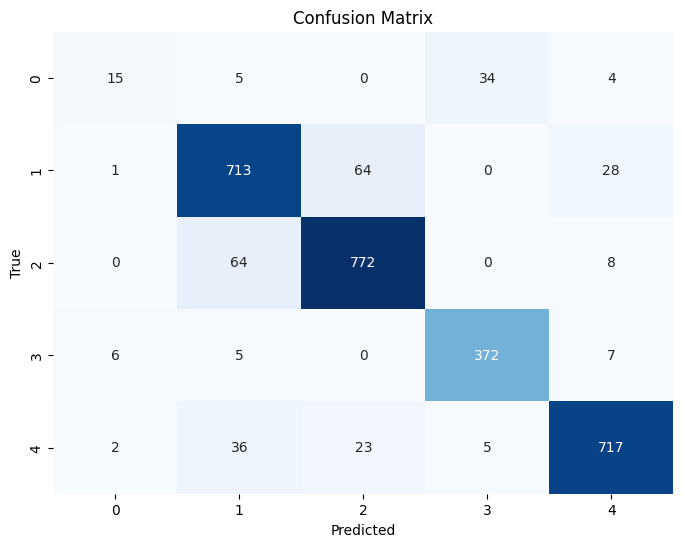

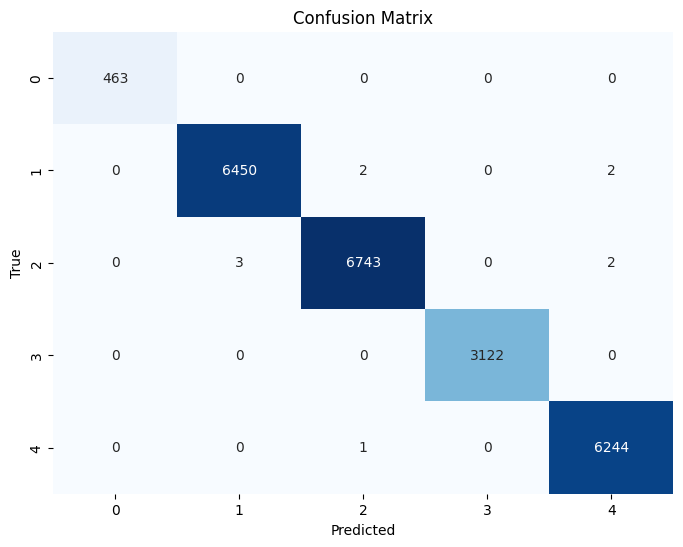

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrixy
conf_matrix_val = confusion_matrix(Y_train, svm_classifier.predict(X_train))
conf_matrix_train = confusion_matrix(Y_val, svm_classifier.predict(X_val))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Grid search

In [17]:
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
import gc
def accuracy_score_wrapper(y, y_hat):
    """
    A wrapper function to convert labels to float32,
    and pass it to accuracy_score.

    Params:
    - y: The y labels that need to be converted
    - y_hat: The predictions made by the model
    """
    gc.collect()
    y = y.astype("float32")  # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)

accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)

In [35]:
import cuml
cuml.common.logger.set_level(1)
from cuml.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train_cupy = le.fit_transform(Y_train)
Y_train = Y_train_cupy.to_numpy()
Y_val_cupy = le.transform(Y_val)
Y_val = Y_val_cupy.to_numpy()
Y_test_cupy = le.transform(Y_test)
Y_test = Y_test_cupy.to_numpy()

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class GarbageCollector(BaseEstimator, TransformerMixin):
    """
    cuml is allocating models on heap memory and it is not being GCed with every gridsearch iteration.
    Forcibly release the memory by calling gc.collect() after every fit and transform.
    Include in gridsearch pipeline.
	"""
    def __init__(self):
        self.variables = 'tes'
    def fit(self, X, y = None):
        gc.collect()
        return self
    def transform(self, X):
        gc.collect()
        return X

In [40]:
# GPU SVM
from cuml.svm import SVC
cuml.common.logger.set_level(1)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# train the SVM classifier
# C is a hyperparameter that controls the trade-off between maximizing the margin and minimizing the classification error.
# C represents the inverse of the regularization strength—smaller, C implies more regularization, larger, C implies less regularization
# poly, rbf, linear
svm_classifier = SVC(kernel="rbf", C=5, gamma=0.001, verbose = 2)
svm_classifier.fit(X_train, Y_train)

# training accuracy
y_pred = svm_classifier.predict(X_train)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_train, y_pred)
print("training accuracy:", accuracy)

cv_scores = cross_val_score(svm_classifier, X_train, Y_train, cv=5)
print("cross-val accuracy:", cv_scores.mean())
val_score = accuracy_score(Y_val, svm_classifier.predict(X_val))
print("val accuracy:", val_score)
test_score = accuracy_score(Y_test, svm_classifier.predict(X_test))
print("test accuracy:", test_score)

training accuracy: 0.9995658214657868
cross-val accuracy: 0.8872872114181518
val accuracy: 0.8982992016660881
test accuracy: 0.8996179228898923


In [15]:
#GPU PCA
from sklearn.decomposition import PCA
# from sklearn.svm import SVC
from cuml.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler
# Define the pipeline
pipe_pca_svm = Pipeline([("garCollect", GarbageCollector()),
                         ("svm", SVC(random_state=42, verbose=2))])
#svm = SVC(random_state=42, verbose=2)
# Define the parameter grid
param_grid_pca_svm = {
    "svm__C": [0.5, 0.75, 1, 2.5, 5],
    "svm__gamma": [0.001, 0.01, 0.1, 0.5],
    "svm__kernel": ["rbf", "poly", "sigmoid"],
}
# initialize grid search
grid_search_pca_svm = GridSearchCV(
    estimator=pipe_pca_svm, param_grid=param_grid_pca_svm, cv=5, scoring=cuml_accuracy_scorer,
    verbose=10, n_jobs=1
)
grid_search_pca_svm.fit(X_train, Y_train)

print("Best parameters for PCA + SVM:", grid_search_pca_svm.best_params_)
print(
    "Best cross-validation accuracy score: {:.2f}".format(
        grid_search_pca_svm.best_score_
    )
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf..............
[CV 1/5; 1/60] END svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf;, score=0.843 total time=   9.0s
[CV 2/5; 1/60] START svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf..............
[CV 2/5; 1/60] END svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf;, score=0.848 total time=   8.0s
[CV 3/5; 1/60] START svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf..............
[CV 3/5; 1/60] END svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf;, score=0.845 total time=   8.1s
[CV 4/5; 1/60] START svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf..............
[CV 4/5; 1/60] END svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf;, score=0.855 total time=   8.2s
[CV 5/5; 1/60] START svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf..............
[CV 5/5; 1/60] END svm__C=0.5, svm__gamma=0.001, svm__kernel=rbf;, score=0.839 total time=   8.1s
[CV 1/5; 2/60] START svm__C=0.5, svm__gamma

In [16]:
# save model
import joblib
joblib.dump(grid_search_pca_svm, "grid_search_svm.pkl")
pd.DataFrame(grid_search_pca_svm.cv_results_).to_csv("grid_search_svm_results.csv")

['grid_search_svm.pkl']

In [41]:
## Load in model if already trained
import joblib
grid_search_pca_svm = joblib.load("grid_search_svm.pkl")

In [44]:
print("metrics for grid search svm")
y_val_pred = grid_search_pca_svm.predict(X_val)
print("val accuracy:", accuracy_score(Y_val_cupy.to_numpy(), y_val_pred))
y_test_pred = grid_search_pca_svm.predict(X_test)
print("test accuracy:", accuracy_score(Y_test_cupy.to_numpy(), y_test_pred))

metrics for grid search svm
val accuracy: 0.8982992016660881
test accuracy: 0.8996179228898923


In [29]:
# Grid search non GPU
from sklearn.decomposition import PCA
# from sklearn.svm import SVC
from cuml.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipe_pca_svm = Pipeline([("svm", SVC(random_state=42))])

# Define the parameter grid
param_grid_pca_svm = {
    "svm__C": [0.5, 0.75, 1, 2.5, 5],
    "svm__gamma": [0.001, 0.01, 0.1, 0.5],
    "svm__kernel": ["rbf", "poly", "sigmoid"],
}
# initialize grid search
grid_search_pca_svm = GridSearchCV(
    estimator=pipe_pca_svm, param_grid=param_grid_pca_svm, cv=5, scoring="accuracy"
)
grid_search_pca_svm.fit(X_train, Y_train)

print("Best parameters for PCA + SVM:", grid_search_pca_svm.best_params_)
print(
    "Best cross-validation accuracy score: {:.2f}".format(
        grid_search_pca_svm.best_score_
    )
)


In [ ]:
# Grid search LDA non GPU
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

pipe_lda_logreg = Pipeline(
    [
        ("lda", LDA()),
        (
            "logreg",
            LogisticRegression(penalty="l1", solver="liblinear", random_state=42),
        ),
    ]
)

n_features = X_train.shape[1]
n_classes = len(np.unique(Y_train))
max_components = min(n_features, n_classes - 1)

# Define the parameter grid
param_grid_lda_logreg = {
    "lda__n_components": list(range(1, max_components + 1)),
    "logreg__C": [0.01, 0.1, 1, 10, 100],
}

# initialize grid search
grid_search_lda_logreg = GridSearchCV(
    estimator=pipe_lda_logreg,
    param_grid=param_grid_lda_logreg,
    cv=5,
    scoring="accuracy",
)
grid_search_lda_logreg.fit(X_train, Y_train)

# Printing the best parameters and the corresponding score
print(
    "Best parameters for LDA + Logistic Regression (L1):",
    grid_search_lda_logreg.best_params_,
)
print(
    "Best cross-validation accuracy score: {:.2f}".format(
        grid_search_lda_logreg.best_score_
    )
)

In [20]:
# Grid search LDA non GPU
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

pipe_lda_logreg = Pipeline(
    [
        ("lda", LDA()),
        (
            "logreg",
            LogisticRegression(penalty="l1", solver="liblinear", random_state=42),
        ),
    ]
)

n_features = X_train.shape[1]
n_classes = len(np.unique(Y_train))
max_components = min(n_features, n_classes - 1)

# Define the parameter grid
param_grid_lda_logreg = {
    "lda__n_components": list(range(1, max_components + 1)),
    "logreg__C": [0.01, 0.1, 1, 10, 100],
    
}

# initialize grid search
grid_search_lda_logreg = GridSearchCV(
    estimator=pipe_lda_logreg,
    param_grid=param_grid_lda_logreg,
    cv=5,
    scoring="accuracy",
    verbose=10
)
grid_search_lda_logreg.fit(X_train, Y_train)

# Printing the best parameters and the corresponding score
print(
    "Best parameters for LDA + Logistic Regression (L1):",
    grid_search_lda_logreg.best_params_,
)
print(
    "Best cross-validation accuracy score: {:.2f}".format(
        grid_search_lda_logreg.best_score_
    )
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START lda__n_components=1, logreg__C=0.01........................
[CV 1/5; 1/20] END lda__n_components=1, logreg__C=0.01;, score=0.645 total time=  22.8s
[CV 2/5; 1/20] START lda__n_components=1, logreg__C=0.01........................
[CV 2/5; 1/20] END lda__n_components=1, logreg__C=0.01;, score=0.651 total time=  17.3s
[CV 3/5; 1/20] START lda__n_components=1, logreg__C=0.01........................
[CV 3/5; 1/20] END lda__n_components=1, logreg__C=0.01;, score=0.646 total time=  20.7s
[CV 4/5; 1/20] START lda__n_components=1, logreg__C=0.01........................
[CV 4/5; 1/20] END lda__n_components=1, logreg__C=0.01;, score=0.650 total time=  17.2s
[CV 5/5; 1/20] START lda__n_components=1, logreg__C=0.01........................
[CV 5/5; 1/20] END lda__n_components=1, logreg__C=0.01;, score=0.655 total time=  16.9s
[CV 1/5; 2/20] START lda__n_components=1, logreg__C=0.1.........................
[CV 1/5; 2/2

In [21]:
# save model
import joblib
joblib.dump(grid_search_lda_logreg, "grid_search_lda_logreg.pkl")
pd.DataFrame(grid_search_lda_logreg.cv_results_).to_csv("grid_search_lda_logreg_results.csv")

['grid_search_lda_logreg.pkl']

In [45]:
grid_search_lda_logreg = joblib.load("grid_search_lda_logreg.pkl")

In [47]:
print("metrics for grid search lda + logreg")
y_val_pred = grid_search_lda_logreg.predict(X_val)
print("val accuracy:", accuracy_score(Y_val_cupy.to_numpy(), y_val_pred))
y_test_pred = grid_search_lda_logreg.predict(X_test)
print("test accuracy:", accuracy_score(Y_test_cupy.to_numpy(), y_test_pred))

metrics for grid search lda + logreg
val accuracy: 0.8833738285317598
test accuracy: 0.8937130948245918


Test

pipeline resnet

In [38]:
# val data
import pandas as pd

csv_file_path = "/content/drive/MyDrive/galaxy_zoo/test_data_reduced.csv"
column_names = ["path", "index", "label"]
df_test = pd.read_csv(csv_file_path, names=column_names)
df_test = df_test.iloc[1:]
df_test = df_test.reset_index(drop=True)
print(df_test.shape)

(250, 3)


In [39]:
images_list_nopreprocess_test = preprocess_resnet_nopreprocess(df_test)
print(len(images_list_nopreprocess_test))

250


In [40]:
# test
custom_dataset_test = CustomDataset(images_list_nopreprocess_test, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset_test, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features_test = resnet(batch.to(device))
        features_list.append(features_test)

# Concatenate features from all batches
features_test = torch.cat(features_list, dim=0)

print(features_test.shape)

torch.Size([250, 2048, 1, 1])


In [41]:
import pandas as pd

features_test = features_test.cpu()
# reshape it to 2000,2048
reshaped_features_test = features_test.squeeze().numpy()
reshaped_features_test = reshaped_features_test.reshape(
    reshaped_features_test.shape[0], -1
)
# Convert to DataFrame
df_features_test = pd.DataFrame(reshaped_features_test)
# Display the DataFrame
print(df_features_test.shape)
df_features_test.head(3)

(250, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.167135,0.381176,0.493124,0.691150,0.210178,0.155488,1.118373,1.231105,0.341808,1.088273,...,0.229235,0.524464,0.627330,0.755175,0.546383,0.090497,0.814885,0.566080,0.757683,0.222192
1,0.289994,0.542519,0.554940,0.685290,0.220291,0.310445,0.326791,0.277052,0.338589,0.481674,...,0.304570,0.503192,0.412349,0.664340,0.850420,0.206360,0.121112,0.089873,0.441404,0.414182
2,0.673329,0.537883,0.790383,0.312683,0.642391,0.992894,0.107670,0.341615,0.423052,0.241216,...,0.269985,0.226813,0.578487,0.411936,0.280815,0.339821,0.588325,0.490038,0.814451,0.271846


In [42]:
test_features = df_features_test.values
top_components = 100

resnet_test_pca_feature = pick_top_feature_pca_val_test(
    pca_train_resnet, test_features, top_components
)
df_top_100_feature_pca_resnet_test = pd.DataFrame(resnet_test_pca_feature)
df_top_100_feature_pca_resnet_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.151431,0.228288,-2.496917,0.343231,3.514340,1.409803,-0.565030,-1.798233,1.249460,0.562218,...,-0.551270,0.098003,-0.211045,0.197097,0.530517,0.452060,-0.128346,0.921105,-0.440701,-0.991959
1,4.735031,0.453660,0.953706,-1.526270,0.979842,-0.061070,-0.396701,0.109710,-4.509008,0.148838,...,-0.249475,-0.057720,-1.127594,0.790057,0.004476,0.182434,0.673582,-0.748875,-0.397216,0.515880
2,-0.522715,-4.190574,1.782997,0.124545,-2.565448,0.056664,-0.463572,1.728248,0.457445,-0.356052,...,0.262039,-0.430448,0.930126,-0.983385,-0.240409,-0.462527,0.067011,-0.648833,-0.254018,0.691980


In [43]:
Y_test_resnet = df_test["label"]
X_test_resnet = resnet_test_pca_feature
print(X_test_resnet.shape)

(250, 100)


pipeline1

In [44]:
with open("codebook.npy", "rb") as f:
    codebook = np.load(f)
preprocessed_features_test = preprocess_1(df_test, codebook=codebook)
preprocessed_features_test.shape

100%|██████████| 250/250 [00:22<00:00, 11.28it/s]


(250, 200)

In [45]:
Y_val_pipeline1 = df_test["label"]
max_test = np.max(preprocessed_features_test, axis=1)
vector_representations_normalized_test = (
    preprocessed_features_test / max_test[:, np.newaxis]
)
x_test_pipeline1 = vector_representations_normalized_test

pipeline 2

In [46]:
df_preprocessed_2_test = preprocess_2(df_test)
df_preprocessed_2_test.columns = [
    f"feature_{i}" for i in range(len(df_preprocessed_2_test.columns))
]
print(df_preprocessed_2_test.shape)

(250, 63504)


In [47]:
test_features = df_preprocessed_2_test.values
top_components = 200

hog_test_pca_feature = pick_top_feature_pca_val_test(
    pca_train_hog, test_features, top_components
)
df_top_100_feature_pca_hog_test = pd.DataFrame(hog_test_pca_feature)
df_top_100_feature_pca_hog_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.100329,-2.086246,0.524157,0.502610,-0.469294,-0.956327,0.909920,0.276533,-0.136504,0.319989,...,0.027726,0.132454,0.045586,0.086657,-0.039738,-0.174275,0.088690,0.096153,0.263919,0.049217
1,0.065967,-1.829381,1.350630,0.771141,0.262683,-0.584693,0.649360,0.497113,-0.383743,0.339792,...,0.048076,-0.011160,-0.002185,-0.377820,0.171146,-0.106964,0.017579,0.029355,-0.038476,0.105316
2,1.768952,-1.176423,-1.836310,-0.991434,-0.722590,1.067262,-0.330562,0.822672,-0.018184,-0.705038,...,0.065077,-0.006136,-0.022082,-0.100231,-0.062286,0.021007,0.079572,0.117903,-0.051344,-0.176417


In [48]:
df_top_100_feature_pca_hog_test_normalized = feature_normalization(
    df_top_100_feature_pca_hog_test
)

In [49]:
X_test_hog = df_top_100_feature_pca_hog_test_normalized.values

In [50]:
print(x_test_pipeline1.shape, X_test_hog.shape, resnet_test_pca_feature.shape)

(250, 200) (250, 200) (250, 100)


In [51]:
Y_test = df_test["label"]

X_test = np.hstack([x_test_pipeline1, X_test_hog, resnet_test_pca_feature])
print(X_test.shape, Y_test.shape)

(250, 500) (250,)


In [53]:
# test accuracy
X_test_lda = lda.transform(X_test)
y_pred_test = classifier_l1.predict(X_test_lda)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, y_pred_test)
print("test accuracy:", accuracy)

test accuracy: 0.708


In [52]:
# test accuracy

y_pred_test = svm_classifier.predict(X_test)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, y_pred_test)
print("test accuracy:", accuracy)


# for data set having 2000 examples
"""
data set: reduced, 2000 examples, 500 for each
	-LDA + regression
		training accuracy: 0.8975
		cross-val accuracy: 0.8924999999999998
		testing accuracy: 0.708
	-SVM
		training accuracy: 0.9845
		cross-val accuracy: 0.726
		testing accuracy: 0.712

"""

test accuracy: 0.712


'\ndata set: reduced, 2000 examples, 500 for each\n  -LDA + regression\n    training, validation, testing: \n  -SVM\n    training, validation, testing: \n    \n'